# Import Required Packages

In [49]:
import pandas as pd
import numpy as np
import datetime
import keras
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from matplotlib import dates
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.layers import BatchNormalization, Dropout
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
# Load data from https://www.eia.gov
xls = pd.ExcelFile('https://www.eia.gov/dnav/pet/xls/PET_PRI_GND_DCUS_NUS_W.xls')
df = pd.read_excel(xls, 'Data 1', header=None)
df.columns = df.iloc[2]

In [3]:
# Remove unnecessary information and then fill Null value with previous value
df = df.iloc[3: , :]
df = df[['Date','Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df = df.fillna(method = 'backfill')

In [4]:
# Set Date as the index and its freq as "week"
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace = True)
df = df.resample(rule='W').mean()
df.index.freq = 'W'

In [5]:
df.rename(columns={'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)':'Price'}, inplace=True)

In [6]:
# Remove the data before 2000-1-1
df = df['2000':]

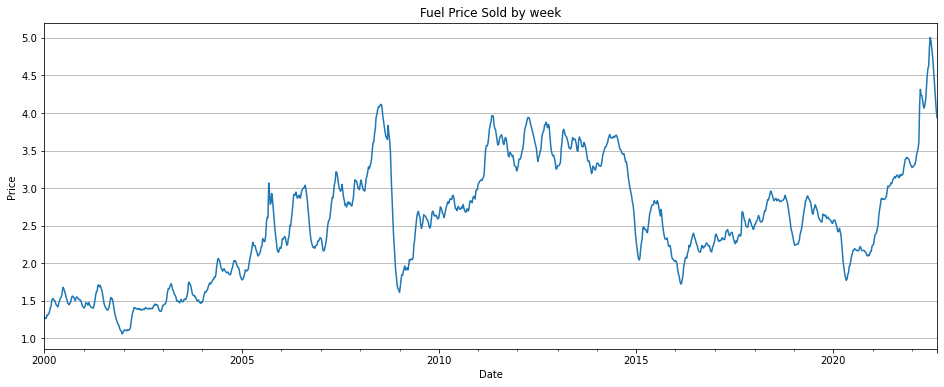

In [8]:
# Line chart
title='Fuel Price Sold by week'
ylabel='Price'
xlabel='Date'

ax = df['Price'].plot(figsize=(16,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
ax.yaxis.grid(True)

# Select Seasonality

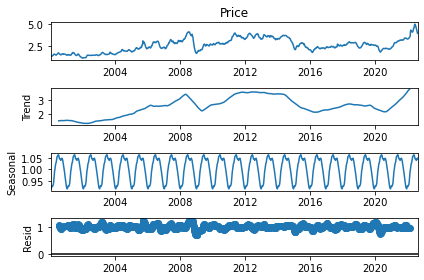

In [9]:
# Use seasonal_decompose to find the seasonality
result = seasonal_decompose(df['Price'], model='mul')
result.plot();

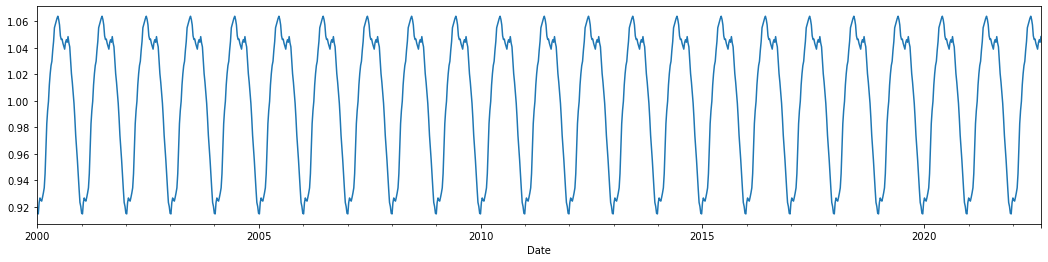

In [10]:
# Choose the seasonality = 52
result.seasonal.plot(figsize=(18,4));

# Split Training & Test Dataset

In [11]:
# Split 20% of all dataset as test data 
percentage = 0.2
n =int(len(df)*percentage)
train_idx = len(df)-n
train = df.iloc[:train_idx]
test = df.iloc[train_idx:]

# SARIMA Model

In [13]:
# Use auto_arima to find the hyper parameters
get_para_model = auto_arima(df['Price'], m=12, trace = True, information_criterion = 'aic')
print('order = ', get_para_model.order)
print('seasonal_order = ', get_para_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-3841.273, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-3379.157, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-3835.778, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-3730.146, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-3379.356, Time=0.13 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-3843.318, Time=2.14 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-3844.563, Time=1.04 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-3843.256, Time=1.67 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-3843.384, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-3832.800, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-3848.475, Time=1.35 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=-3845.863, Time=2.55 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-3845.621, Time=2.46 sec
 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=-3843.620, Time=2.60 sec
 ARIM

In [14]:
# Fit model for training data
model = SARIMAX(train['Price'],order=get_para_model.order,seasonal_order=get_para_model.seasonal_order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Price   No. Observations:                  946
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                1557.096
Date:                              Fri, 19 Aug 2022   AIC                          -3098.192
Time:                                      11:41:57   BIC                          -3059.382
Sample:                                  01-02-2000   HQIC                         -3083.401
                                       - 02-11-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8583      0.108      7.944      0.000       0.647       1.070
ar.L2         -0.9024      0.140     -6.453      0.000      -1.176      -0.628
ar.L3          0.4664      0.055      8.549      0.000       0.359       0.573
ma.L1         -0.3549      0.112     -3.177      0.001      -0.574      -0.136
ma.L2          0.7389      0.116      6.381      0.000       0.512       0.966
ar.S.L12       0.0101      2.215      0.005      0.996      -4.331       4.352
ma.S.L12      -0.0258      2.211     -0.012      0.991      -4.360       4.308
sigma2         0.0022   4.82e-05     44.895      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7228.72
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.66
Prob(H) (two-sided):                  0.88   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

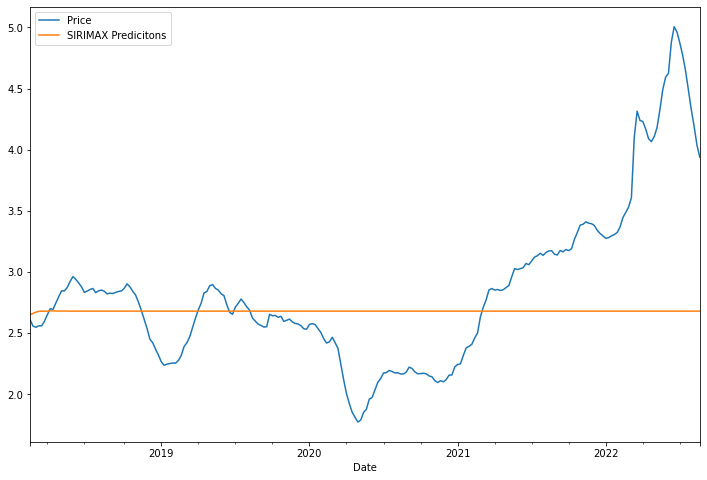

In [15]:
start = len(train)
end = len(df) - 1
predictions = results.predict(start,end,typ='levels').rename('SIRIMAX Predicitons')
test['Price'].plot(legend=True,figsize=(12,8));
predictions.plot(legend=True);

In [16]:
# Refit Model (For all data)
r_model = SARIMAX(df['Price'], order=get_para_model.order, seasonal_order=get_para_model.seasonal_order)
r_results = r_model.fit()
r_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Price   No. Observations:                 1182
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                1934.050
Date:                              Fri, 19 Aug 2022   AIC                          -3852.099
Time:                                      11:42:04   BIC                          -3811.506
Sample:                                  01-02-2000   HQIC                         -3836.796
                                       - 08-21-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9212      0.050     18.520      0.000       0.824       1.019
ar.L2         -1.0529      0.067    -15.678      0.000      -1.184      -0.921
ar.L3          0.5343      0.029     18.428      0.000       0.478       0.591
ma.L1         -0.3819      0.051     -7.532      0.000      -0.481      -0.283
ma.L2          0.8630      0.056     15.368      0.000       0.753       0.973
ar.S.L12       0.1394      0.625      0.223      0.823      -1.085       1.364
ma.S.L12      -0.1913      0.617     -0.310      0.756      -1.400       1.018
sigma2         0.0022   3.42e-05     64.780      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             16248.10
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             1.21
Prob(H) (two-sided):                  0.25   Kurtosis:                        21.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

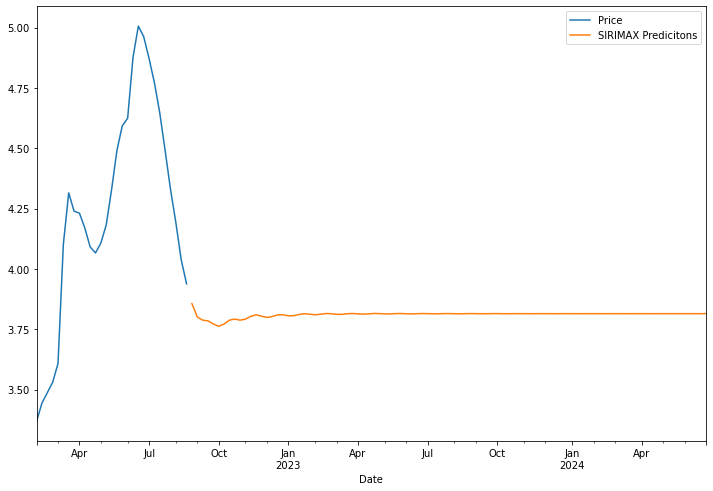

In [17]:
# Forecast next 24 months
fct_months = 24
arima_fcast = r_results.predict(len(df),len(df)+fct_months*4,typ='levels').rename('SIRIMAX Predicitons')
df['2022-2':]['Price'].plot(legend=True,figsize=(12,8));
arima_fcast.plot(legend=True);

# RNN LSTM Model

In [18]:
df_rnn = df[['Price']]

In [19]:
# Implement MinMaxScaler into train & test data set
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
# Choose n_input & n_features
# n_input = 52 because seasonality is 52
# n_features = 1 because we want to predict just one value
n_input = 52
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
# Build a RNN model
# Model structure was decided by experiment
model = Sequential()

model.add(LSTM(220,activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(120,activation='relu', return_sequences=True))
model.add(LSTM(80,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 220)           195360    
                                                                 
 lstm_1 (LSTM)               (None, 52, 120)           163680    
                                                                 
 lstm_2 (LSTM)               (None, 80)                64320     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 423,441
Trainable params: 423,441
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Model training
model.fit_generator(train_generator, epochs=150)

Epoch 1/150
894/894 [==============================] - 36s 36ms/step - loss: 0.0119
Epoch 2/150
894/894 [==============================] - 32s 36ms/step - loss: 0.0034
Epoch 3/150
894/894 [==============================] - 31s 35ms/step - loss: 0.0019
Epoch 4/150
894/894 [==============================] - 30s 33ms/step - loss: 0.0013
Epoch 5/150
894/894 [==============================] - 30s 33ms/step - loss: 8.5636e-04
Epoch 6/150
894/894 [==============================] - 29s 33ms/step - loss: 7.4014e-04
Epoch 7/150
894/894 [==============================] - 29s 33ms/step - loss: 8.6464e-04
Epoch 8/150
894/894 [==============================] - 29s 33ms/step - loss: 6.7958e-04
Epoch 9/150
894/894 [==============================] - 30s 33ms/step - loss: 7.2700e-04
Epoch 10/150
894/894 [==============================] - 30s 33ms/step - loss: 6.6253e-04
Epoch 11/150
894/894 [==============================] - 30s 33ms/step - loss: 6.4584e-04
Epoch 12/150
894/894 [========================

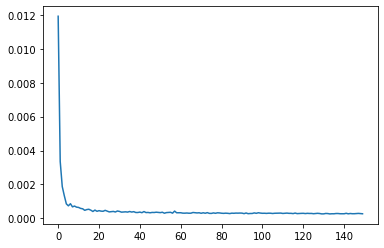

In [23]:
# Loss-Epoch line chart
loss = model.history.history['loss']
epochs =range(len(loss))
plt.plot(epochs, loss);

# Performance on Test data

In [24]:
# Hold predictions
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

# reshape this to the format RNN wants
current_batch = first_eval_batch.reshape((1,n_input,n_features))

# How far into futue will I forecast?
for i in range(len(test)):
    
    # One timestep ahead of hitorical 12 points
    current_pred = model.predict(current_batch)[0]
    
    # Record this prediction
    test_predictions.append(current_pred)
    
    # Update current batch to include prediction and remove the first data point
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Transfer predictions to input scale
true_predictions = scaler.inverse_transform(test_predictions)

1/1 [==============================] - 0s 19ms/step


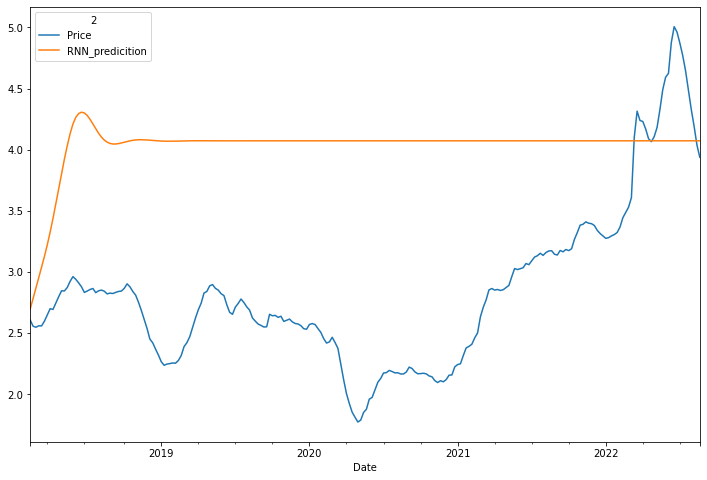

In [25]:
test['RNN_predicition'] = true_predictions
test.plot(figsize=(12,8));

# Forecast next 24 months

In [26]:
fct_months = 24

fct_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)+fct_months*4):
    current_pred = model.predict(current_batch)[0]
    fct_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_prediction_fct = scaler.inverse_transform(fct_predictions)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


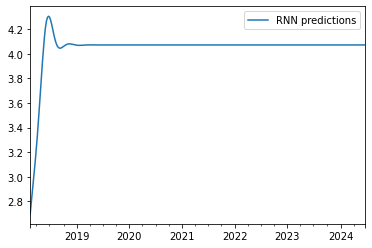

In [32]:
rnn_time_index = pd.date_range(start='2018-02-18', periods=len(true_prediction_fct), freq='w')
rnn_predict_df = pd.DataFrame(true_prediction_fct, index=rnn_time_index)
rnn_predict_df.columns = ['RNN predictions']
rnn_predict_df.plot();

# Compare SARIMA & RNN model

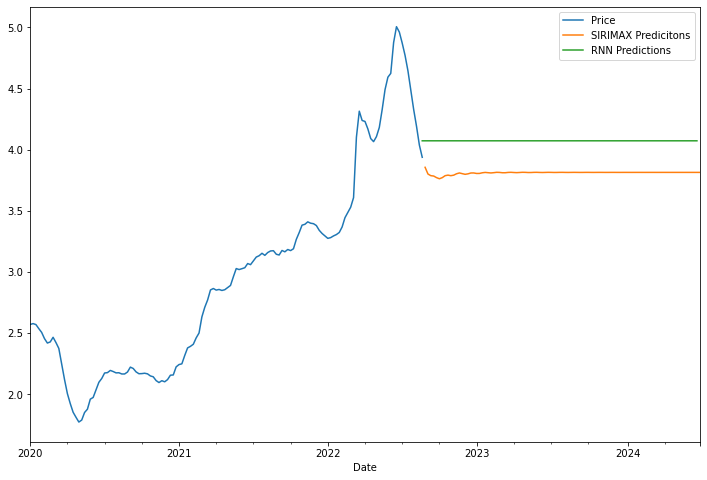

In [33]:
# Plot them in the same chart
compare_rnn_fct = rnn_predict_df['2022-08-16':].squeeze()
compare_rnn_fct = compare_rnn_fct.rename('RNN Predictions')
df['Price']['2020':].plot(legend=True,figsize=(12,8));
arima_fcast.plot(legend=True);
compare_rnn_fct.plot(legend=True);

In [37]:
# Compare metrices (MSE & MAE)
print('MSE')
print('SARIMA Model: ', mean_squared_error(test['Price'], predictions))
print('RNN Model: ', mean_squared_error(test['Price'], true_predictions))
print("")
print('MAE')
print('SARIMA Model: ', mean_absolute_error(test['Price'], predictions))
print('RNN Model: ', mean_absolute_error(test['Price'], true_predictions))

MSE
SARIMA Model:  0.4576377686009373
RNN Model:  1.8932766416107294

MAE
SARIMA Model:  0.4698223186442259
RNN Model:  1.2668380005672826


In [73]:
# Create a function that get the predicted price for the following week by using the model with lower MSE
sarima_mse = mean_squared_error(test['Price'], predictions)
rnn_mse = mean_squared_error(test['Price'], true_predictions)

def get_predicted_trend(today_price):
    
    today = datetime.date.today()
    coming_Sunday_date = today + datetime.timedelta(6-today.weekday(), weeks=0)
    coming_Sunday = coming_Sunday_date.strftime("%m/%d/%Y")

    rnn_price = round(rnn_predict_df['RNN predictions'][coming_Sunday],2)
    sarima_price = round(predictions[coming_Sunday],2)
    
    if sarima_mse <= rnn_mse:    
        if today_price >= sarima_price:
            sarima_trend = '[SARIMA Model] Fuel price will go down to ${} in a week'.format(sarima_price)
        else:
            sarima_trend = '[SARIMA Model] Fuel price will go up to ${} in a week'.format(sarima_price)
        return sarima_trend
    else:
        if today_price >= rnn_price:
            rnn_trend = '[RNN Model] Fuel price will go down to ${} in a week'.format(rnn_price)
        else:
            rnn_trend = '[RNN Model] Fuel price will go up to ${} in a week'.format(rnn_price)
        return rnn_trend

# Use Case Example

In [74]:
get_predicted_trend(2)

'[SARIMA Model] Fuel price will go up to $2.68 in a week'

In [75]:
get_predicted_trend(2.775)

'[SARIMA Model] Fuel price will go down to $2.68 in a week'

In [76]:
get_predicted_trend(3)

'[SARIMA Model] Fuel price will go down to $2.68 in a week'